# **Water Pipeline Leak Prediction**

#### **Setup & Imports**

In [2]:
import pandas as pd
import numpy as np
import re

REP_PATH = "Dataset/Civil_Breakdown_Work_2020_to_Date.xlsx"
PIPES_PATH = "Dataset/Pipelines_Materials_and_Lengths_Raw_Date.xlsx"

#### **Small Helpers**

In [3]:
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).replace("\n", " ").strip() for c in df.columns]
    return df

def clean_text(s):
    if pd.isna(s):
        return None
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def norm_key(s):
    if pd.isna(s):
        return None
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

#### **Load Raw Data**

In [4]:
# replace / work orders
rep = pd.read_excel(REP_PATH, sheet_name="Sheet1")
rep = normalize_cols(rep)

# pipe attributes (multi-row header -> header=3)
mat_raw = pd.read_excel(
    PIPES_PATH, 
    sheet_name="IZINTABA SYSTEM MATERIAL update", 
    header=3
)

#### **Select Relevant Columns & Standardize**

In [5]:
# keep only useful columns
rep_keep = [
    "Order", "Order Type","Priority","Problem_Description",
    "MaintActivType","System status", "Sched. start",
    "Sched. finish","Basic start","Basic finish","Actual start",
    "Actual finish", "Functional Loc.","Equipment","Description",
    "Location_Description", "Total act.costs","TotalPlnndCosts"
]
rep = rep[[c for c in rep_keep if c in rep.columns]].copy()

# clean text columns in rep
for c in [
    "Problem_Description", "MaintActivType", "Functional Loc.",
    "Equipment", "Description", "Location_Description"
]:
    if c in rep.columns:
        rep[c] = rep[c].apply(clean_text)

# rename pipeline sheet columns to canonical names
rename_map = {
    "System": "SYSTEM",
    "Sub system ": "SUB SYSTEM",
    "Sub system": "SUB SYSTEM",
    "Pipeline Name": "PIPELINE NAME",
    "Length (km)": "TOTAL LENGTH (KM)",
    "(mm)": "Nominal Diameter",
    "Material": "Material",
    "(Mℓ/day)": "CAPACITY MLD",
    "(years)": "PIPELINE AGE",
    "From": "FROM",
    "To": "TO"
}
mat = mat_raw.rename(columns=rename_map)

# keep relevant columns
mat_keep = [
    "SYSTEM", "SUB SYSTEM", "PIPELINE NAME", "FROM","TO", "TOTAL LENGTH (KM)",
    "Nominal Diameter","Material","CAPACITY MLD","PIPELINE AGE"
]
mat = mat[[c for c in mat_keep if c in mat.columns]].copy()

# clean text in mat
for c in ["SYSTEM","SUB SYSTEM","PIPELINE NAME","FROM","TO","Material"]:
    if c in mat.columns:
        mat[c] = mat[c].apply(clean_text)

# numeric casting
for nc in ["TOTAL LENGTH (KM)","Nominal Diameter","CAPACITY MLD","PIPELINE AGE"]:
    if nc in mat.columns:
        mat[nc] = pd.to_numeric(mat[nc], errors="coerce")

#### **Create Leak/Failure Label**

In [6]:
leak_kw = r"(leak|leaking|leakage|burst|pipe burst|pipeline burst|bursting|pipe break|pipe failure|repair pipe|repair leak)"

def has_leak_flag(row):
    text = " ".join([
        str(row.get("Problem_Description") or ""),
        str(row.get("MaintActivType") or ""),
    ]).lower()
    code = (row.get("MaintActivType") or "").strip().upper()
    # extend if your data uses other codes
    code_hint = code in {"DBN", "DB", "BRK", "RPR"}
    return int(bool(re.search(leak_kw, text)) or code_hint)

rep["target_leak"] = rep.apply(has_leak_flag, axis=1)

#### **Parse Event Dates**

In [7]:
date_cols_priority = [
    "Actual start", "Sched. start", "Basic start",
    "Actual finish", "Sched. finish", "Basic finish"
]

def parse_best_date(row):
    for dc in date_cols_priority:
        if dc in rep.columns and pd.notna(row.get(dc)):
            try:
                return pd.to_datetime(row.get(dc))
            except Exception:
                continue
    return pd.NaT

rep["event_date"] = rep.apply(parse_best_date, axis=1)
rep["event_year"] = pd.to_datetime(rep["event_date"], errors="coerce").dt.year
rep["event_month"] = pd.to_datetime(rep["event_date"], errors="coerce").dt.month

#### **Build Join Keys**

In [8]:
# asset key from replacement orders
asset_candidates = ["Functional Loc.", "Description", "Location_Description"]
rep["asset_key_raw"] = None
for c in asset_candidates:
    if c in rep.columns:
        rep["asset_key_raw"] = rep["asset_key_raw"].fillna(rep[c])
rep["asset_key"] = rep["asset_key_raw"].apply(norm_key)

# pipeline key from attributes
if "PIPELINE NAME" in mat.columns:
    mat["pipe_key_raw"] = mat["PIPELINE NAME"].fillna(mat.get("SUB SYSTEM"))
else:
    mat["pipe_key_raw"] = mat.get("SUB SYSTEM")
mat["pipe_key"] = mat["pipe_key_raw"].apply(norm_key)

#### **Exact Join**

In [9]:
rep_nonnull = rep.dropna(subset=["asset_key"]).copy()
mat_nonnull = mat.dropna(subset=["pipe_key"]).copy()

merged_exact = rep_nonnull.merge(
    mat_nonnull,
    left_on="asset_key", right_on="pipe_key",
    how="left", suffixes=("_rep","_pipe")
)

exact_match_rate = (merged_exact["pipe_key"].notna().mean() * 100) if len(merged_exact) else 0.0
print(f"Exact match rate: {exact_match_rate:.2f}%")


Exact match rate: 0.00%


#### **Heuristic Mapping by Shared Numbers**

In [10]:
def extract_numbers(s):
    if not isinstance(s, str): 
        return []
    return re.findall(r"\b(\d{1,4})\b", s)

rep_num = rep.copy()
rep_num["nums"] = rep_num["asset_key_raw"].apply(
    lambda x: extract_numbers(x) if pd.notna(x) else []
)

mat_num = mat.copy()
if "PIPELINE NAME" in mat_num.columns:
    mat_num["nums"] = mat_num["PIPELINE NAME"].apply(
        lambda x: extract_numbers(x) if pd.notna(x) else []
    )
else:
    mat_num["nums"] = [[] for _ in range(len(mat_num))]

rep_ex = rep_num.explode("nums")
mat_ex = mat_num.explode("nums")

num_merge = rep_ex.merge(
    mat_ex[[
        "PIPELINE NAME", "SYSTEM","SUB SYSTEM", "TOTAL LENGTH (KM)",
        "Nominal Diameter", "Material", "CAPACITY MLD", "PIPELINE AGE", "nums"
    ]],
    on="nums", how="left", suffixes=("","_mat")
)

best_by_order = (
    num_merge.sort_values(
        ["Order","nums"]
    ).groupby("Order").agg({
                     "PIPELINE NAME":"first",
                     "SYSTEM":"first",
                     "SUB SYSTEM":"first",
                     "TOTAL LENGTH (KM)":"first",
                     "Nominal Diameter":"first",
                     "Material":"first",
                     "CAPACITY MLD":"first",
                     "PIPELINE AGE":"first"
                    }).reset_index().rename(columns={
                     "PIPELINE NAME":"heur_PIPELINE NAME",
                     "SYSTEM":"heur_SYSTEM",
                     "SUB SYSTEM":"heur_SUB SYSTEM",
                     "TOTAL LENGTH (KM)":"heur_TOTAL LENGTH (KM)",
                     "Nominal Diameter":"heur_Nominal Diameter",
                     "Material":"heur_Material",
                     "CAPACITY MLD":"heur_CAPACITY MLD",
                     "PIPELINE AGE":"heur_PIPELINE AGE"
                    })
)


#### **Assemble Final Training Dataset**

In [11]:
# start from exact merge
merged = merged_exact.copy()

# add heuristic columns by Order
merged = merged.merge(best_by_order, on="Order", how="left")

def fill_choice(row, exact, heur):
    v = row.get(exact)
    return row.get(heur) if (pd.isna(v) or v in ["", None]) else v

for base in [
    "PIPELINE NAME", "SYSTEM", "SUB SYSTEM", "TOTAL LENGTH (KM)",
    "Nominal Diameter", "Material", "CAPACITY MLD", "PIPELINE AGE"
]:
    exact = base
    heur = f"heur_{base}"
    if exact in merged.columns or heur in merged.columns:
        merged[f"final__{base}"] = merged.apply(
            lambda r: fill_choice(r, exact, heur), axis=1
        )

final_cols = [
    # labels & dates
    "Order","Order Type","Priority","MaintActivType","Problem_Description",
    "event_date","event_year","event_month","target_leak",
    # asset refs
    "Functional Loc.","Equipment","Description","Location_Description",
    # attributes
    "final__PIPELINE NAME","final__SYSTEM","final__SUB SYSTEM",
    "final__TOTAL LENGTH (KM)","final__Nominal Diameter","final__Material",
    "final__CAPACITY MLD","final__PIPELINE AGE"
]
final_cols = [c for c in final_cols if c in merged.columns]
dataset = merged[final_cols].copy()

#### **Save Outputs**

In [12]:
# save dataframe
dataset.to_pickle('pipe_leak_training_dataset_fresh.pkl')

In [13]:
vc = dataset["target_leak"].value_counts(dropna=False)
pct = (vc / len(dataset) * 100).round(2)
print("Class counts:\n", vc.to_string())
print("\nClass %:\n", pct.to_string())

Class counts:
 target_leak
0    5127
1    1133

Class %:
 target_leak
0    81.9
1    18.1


C:\Users\samke\AppData\Local\Temp\ipykernel_12592\1833726185.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="viridis")


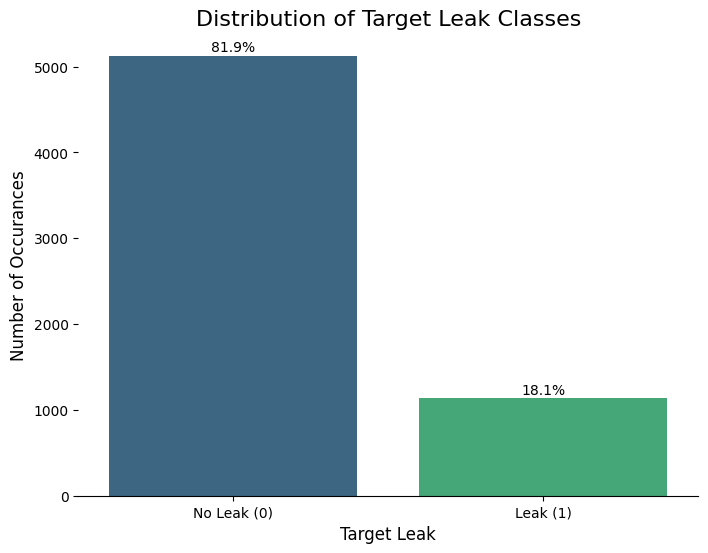

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# use seaborn to create bar plot
sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="viridis")

# add the percentage labels to the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
        height + 50,
        f"{pct.values[i]}%",
        ha="center"
    )

ax.set_title("Distribution of Target Leak Classes", fontsize=16)
ax.set_xlabel("Target Leak", fontsize=12)
ax.set_ylabel("Number of Occurances", fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Leak (0)", "Leak (1)"])

sns.despine(left=True)
plt.show()

In [15]:
counts = dataset["target_leak"].value_counts()
w0 = (1.0 / counts[0])
w1 = (1.0 / counts[1]) if 1 in counts else w0
CLASS_WEIGHT = {0: float(w0), 1: float(w1)}
CLASS_WEIGHT


{0: 0.0001950458357714063, 1: 0.00088261253309797}